# NLP From Scratch: Generating Names With A Character-Level RNN

## Preparing the Data

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1 # Plus EOS marker

def findFiles(path): return glob.glob(path)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

# Build the category_lines dictionary, a list of lines per category
category_lines = {}
all_categories = []
for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

if n_categories == 0:
    raise RuntimeError('Data not found. Make sure that you downloaded data '
        'from https://download.pytorch.org/tutorial/data.zip and extract it to '
        'the current directory.')

print('# categories:', n_categories, all_categories)
print(unicodeToAscii("O'Néàl"))


# categories: 18 ['Czech', 'German', 'Arabic', 'Japanese', 'Chinese', 'Vietnamese', 'Russian', 'French', 'Irish', 'English', 'Spanish', 'Greek', 'Italian', 'Portuguese', 'Scottish', 'Dutch', 'Korean', 'Polish']
O'Neal


In [2]:
n_categories, all_categories

(18,
 ['Czech',
  'German',
  'Arabic',
  'Japanese',
  'Chinese',
  'Vietnamese',
  'Russian',
  'French',
  'Irish',
  'English',
  'Spanish',
  'Greek',
  'Italian',
  'Portuguese',
  'Scottish',
  'Dutch',
  'Korean',
  'Polish'])

In [3]:
type(category_lines), all_categories[0]

(dict, 'Czech')

In [4]:
category_lines[all_categories[0]]

['Abl',
 'Adsit',
 'Ajdrna',
 'Alt',
 'Antonowitsch',
 'Antonowitz',
 'Bacon',
 'Ballalatak',
 'Ballaltick',
 'Bartonova',
 'Bastl',
 'Baroch',
 'Benesch',
 'Betlach',
 'Biganska',
 'Bilek',
 'Blahut',
 'Blazek',
 'Blazek',
 'Blazejovsky',
 'Blecha',
 'Bleskan',
 'Blober',
 'Bock',
 'Bohac',
 'Bohunovsky',
 'Bolcar',
 'Borovka',
 'Borovski',
 'Borowski',
 'Borovsky',
 'Brabbery',
 'Brezovjak',
 'Brousil',
 'Bruckner',
 'Buchta',
 'Cablikova',
 'Camfrlova',
 'Cap',
 'Cerda',
 'Cermak',
 'Chermak',
 'Cermak',
 'Cernochova',
 'Cernohous',
 'Cerny',
 'Cerney',
 'Cerny',
 'Cerv',
 'Cervenka',
 'Chalupka',
 'Charlott',
 'Chemlik',
 'Chicken',
 'Chilar',
 'Chromy',
 'Cihak',
 'Clineburg',
 'Klineberg',
 'Cober',
 'Colling',
 'Cvacek',
 'Czabal',
 'Damell',
 'Demall',
 'Dehmel',
 'Dana',
 'Dejmal',
 'Dempko',
 'Demko',
 'Dinko',
 'Divoky',
 'Dolejsi',
 'Dolezal',
 'Doljs',
 'Dopita',
 'Drassal',
 'Driml',
 'Duyava',
 'Dvorak',
 'Dziadik',
 'Egr',
 'Entler',
 'Faltysek',
 'Faltejsek',
 'Fencl',

## Creating the Network

This network extends the character-level rnn classification with an extra argument for the category tensor, which is concatenated along with the others. The category tensor is a one-hot vector just like the letter input.

We will interpret the output as the probability of the next letter. When sampling, the most likely output letter is used as the next input letter.

I added a second linear layer `o2o`(after combining hidden and output) to given it must muscle to work with. There's also a dropout layer, which randomly zeros parts of its input with a givene probability and is usually used to fuzz inputs to prevent overfitting. Here we're using it towards the end of the network to purposely add some chaos and increase sampling variety.

![](https://i.imgur.com/jzVrf7f.png)

In [5]:
import torch
import torch.nn as nn


class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        
        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [6]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter(log_dir='runs/rnn_generation')

## Training

### Preparing for Training

In [7]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l)-1)]


def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category, line

For each timestep the inputs of the network will be `(category, currnet letter, hidden state)` and the outputs will be `(next letter, next hidden state)`. So for each training set, we'll need the category, a set of input letters, and a set of output/target letters.

![](https://i.imgur.com/JH58tXY.png)

In [8]:
len(all_categories), n_categories

(18, 18)

The category tensor is a one-hot tensor of size `<1 * n_categories>`. When training we feed it to the network at every timestep - this is a design choice, it could have been includedw as part of initial hidden state or some other strategy.

In [18]:
# One-hot vector for category
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

# One-hot matrix of first to last letters (not including EOS) for input
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

# LongTensor of second letter to end (EOS) for target
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

For convenience during training we'll make a `randomTrainExample` function that fetcheh a random (category, line) pair and turns them into the required (category, input, target) tensors.

In [20]:
# Make category, input, and target tensors from a random category, line pair
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor

**visualizating computiation graph**

In [36]:
# visualizing the computiation graph

category_tensor, input_line_tensor, _ = randomTrainingExample()

rnn = RNN(n_letters, 128, n_letters)
input_tensor = input_line_tensor[0]
hidden = rnn.initHidden()

writer.add_graph(rnn, (category_tensor, input_tensor, hidden))

## Training the Network

In constrast to classification, where only the last output is used, we are making a prediction at every step, so we can calculating loss at every step.

The magic of autograd allows you to simply sum these losses at each step and call backward at the end.

In [42]:
criterion = nn.NLLLoss()

learning_rate = 5e-4

def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()
    
    rnn.zero_grad()
    
    loss = 0
    
    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l
        
    loss.backward()
    
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)
        
    return output, loss.item() / input_line_tensor.size(0)

To keep track of how training takes I am adding a `timeSince(timestamp)` function which returns a hunman readable string:

In [38]:
import time
import math


def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

Training is business as usual - call train a bunch of times and wait a few minutes, printing the current time and loss every `print_every` examples, and keeping store of an average loss per `plot_every` examples in `all_losses` for plotting later.

In [44]:
rnn = RNN(n_letters, 128, n_letters)


n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0 # Reset every plot_every iters

start = time.time()

for iter in range(1, n_iters+1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss
    
    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))
        
    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        totoal_loss = 0

## Plotting the losses

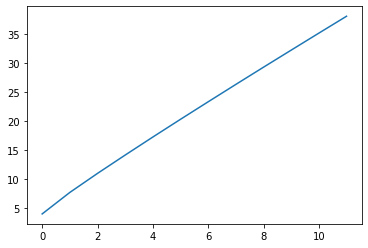

In [45]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

## Sampling the Network

To sample we give the network a letter and ask what the next one is, feed that is as the next letter, and repeat until the EOS token.

* Crate tensors for input category, starting letter, and empty hidden state
* Create a string `output_name` with the starting letter
* Up to maximum output length,
    * Feed the current letter to the network
    * Get the next letter from highest output, and next hidden state
    * If the letter is EOS, stop here
    * If the regular letter, add to output and continue
* Return the final name

> Rather than having to give it a starting letter, another strategy would have been to include a "start of string" token in training and have the network choose its own starting letter.

In [65]:
max_length = 20

# Sample form a category and starting letter

def sample(category, start_letter='A'):
    with torch.no_grad():
        category_tensor = categoryTensor(category)
        input = inputTensor(start_letter)
        hidden = rnn.initHidden()
        
        output_name = start_letter
        
        for i in range(max_length):
            output, hidden = rnn(category_tensor, input[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = inputTensor(letter)
            
        return output_name
    
def sampels(category, start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(category, start_letter))